# Implementação de artigo 
*Leak detection of gas pipelines using acoustic signals based on wavelet
 transform and Support Vector Machin*

 - Pontos Interessantes do artigo:
   - Denoising utilizando transformadas wavelet (DWT)
   - Encontrar a melhor base wavelet para cada sinal a partir da entropiae

# Imports

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
with open('all_samples.npy','rb') as f:
    all_samples = np.load(f)
all_samples = [i.flatten() for i in all_samples]

# Denoising

In [3]:
import pywt
from pywt import swt

def dwt_denoise(signal, wavelet, level):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Aplicando limiarização (thresholding)
    threshold = np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]]  # Manter os coeficientes de aproximação (nível mais alto)
    for i in range(1, len(coeffs)):
        denoised_coeffs.append(pywt.threshold(coeffs[i], threshold, mode='soft'))
    # Reconstruindo o sinal
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

In [21]:
import matplotlib.pyplot as plt
import pywt

def plot_wavelet(signal, wavelet, level):
    #signal = [val[0] for val in signal]
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    fig, axs = plt.subplots(level + 1, 1, figsize=(10, 6))

    # Plot original signal
    axs[0].plot(signal)
    axs[0].set_title('Original Signal')
    axs[1].plot(coeffs[0], label=f'Approximation Coefficients - Level {level}')
    axs[1].set_xlim(0, len(signal))
    
    # Plot approximation and detail coefficients
    for i in range(2, level + 1):
        cD = pywt.upcoef('d', coeffs[i], wavelet, level=i)
        
        # Plot approximation coefficient
        
        # Plot detail coefficient
        axs[i].plot(cD, label=f'Detail Coefficients - Level {i}')
        axs[i].legend(loc='upper right')
        axs[i].set_xlim(0, len(signal))
        
    plt.tight_layout()
    plt.show()


In [18]:
import matplotlib.pyplot as plt
import pywt

def plot_wavelet(signal, wavelet, level):
    
    fig, ax = plt.subplots(level + 1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1] + [1]*level})

    # Plot original signal
    ax[0,0].plot(signal)
    ax[0,0].set_title('Original Signal')
    ax[0,1].remove()
    
    # Plot approximation and detail coefficients
    for i in range(1, level + 1):
        cD = pywt.upcoef('d',signal, wavelet, level=i)
        cA = pywt.upcoef('a', signal, wavelet, level=i)
        # Plot approximation coefficient
        ax[i,0].plot(cA, label=f'Approximation Coefficients - Level {i}')
        # Plot detail coefficient
        ax[i,1].plot(cD, label=f'Detail Coefficients - Level {i}')
        #ax[i,0].legend(loc='upper right')
        #ax[i,1].legend(loc='upper right')
        
    plt.tight_layout()
    plt.show()


In [22]:
wavelet = 'sym17'
level = 5

In [23]:
denoised_samples = []

for wave in all_samples:
    wave = wave.reshape(-1)
    denoised_signal = dwt_denoise(wave, wavelet, level)
    denoised_samples += [denoised_signal]
denoised_samples = np.array(denoised_samples)

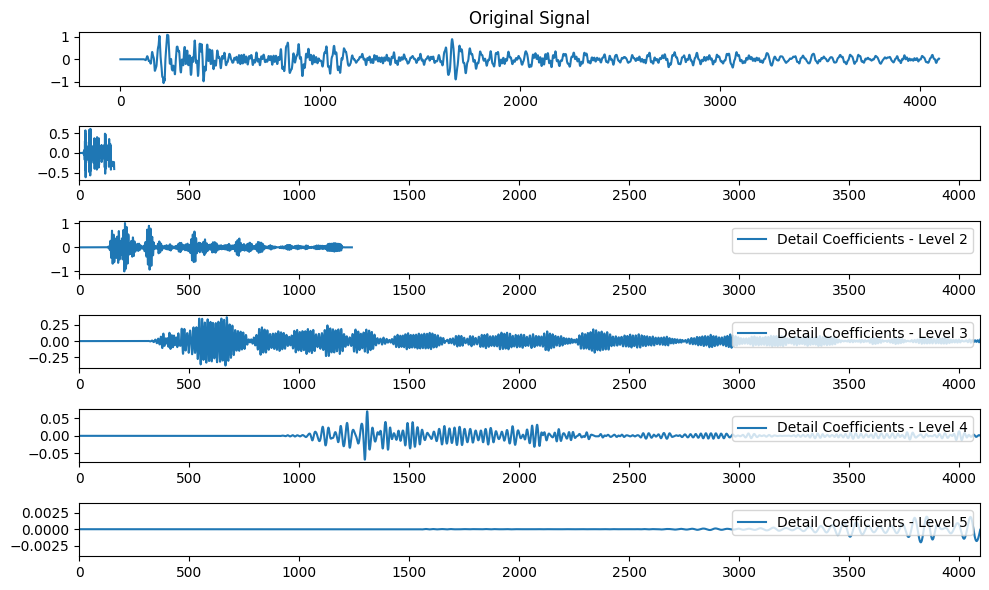

In [24]:
plot_wavelet(all_samples[1], wavelet, 5)

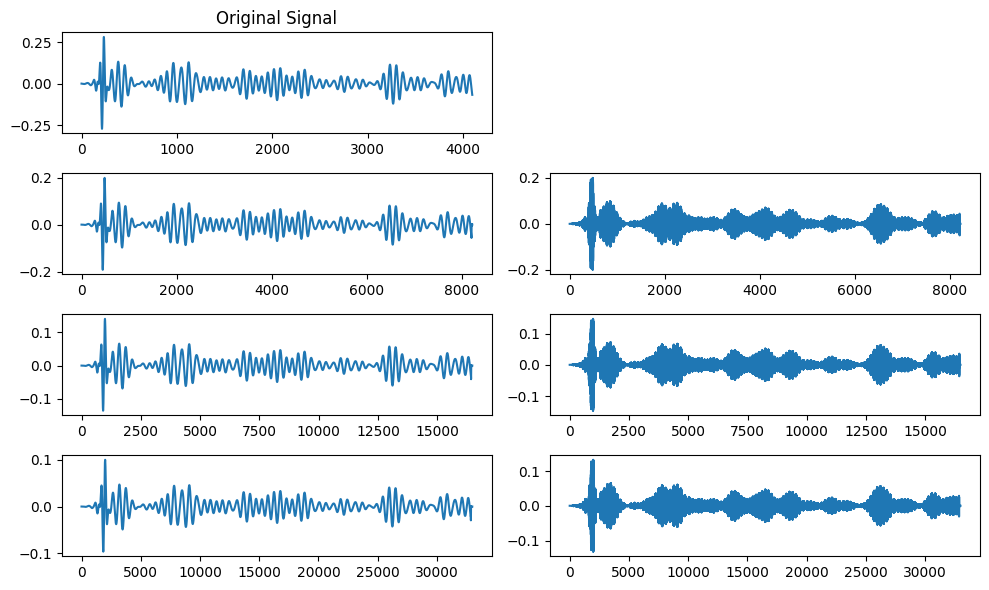

In [19]:
plot_wavelet(denoised_samples[1], wavelet, 3)

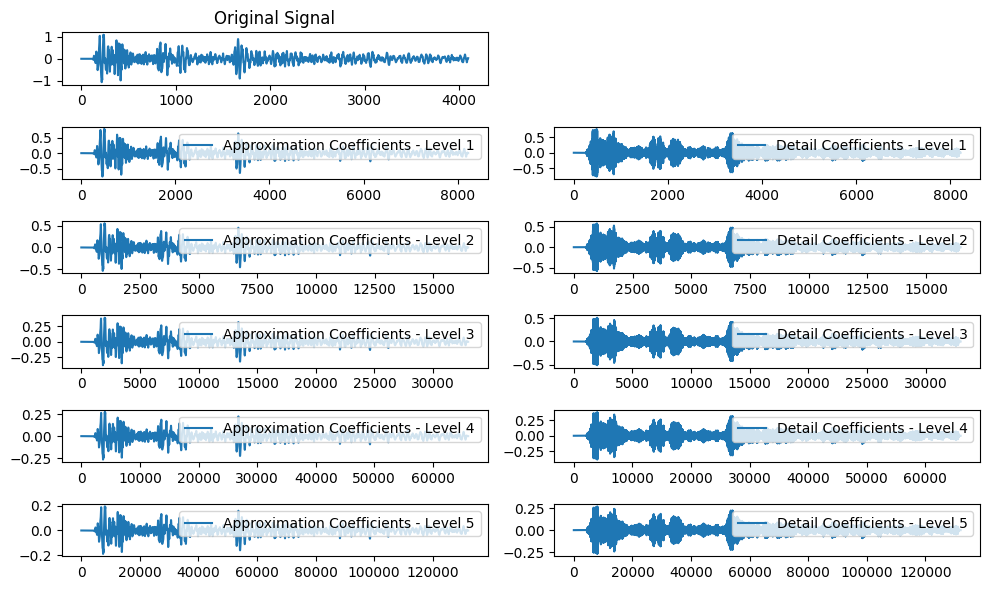

In [10]:
plot_wavelet(all_samples[1], wavelet, 5)

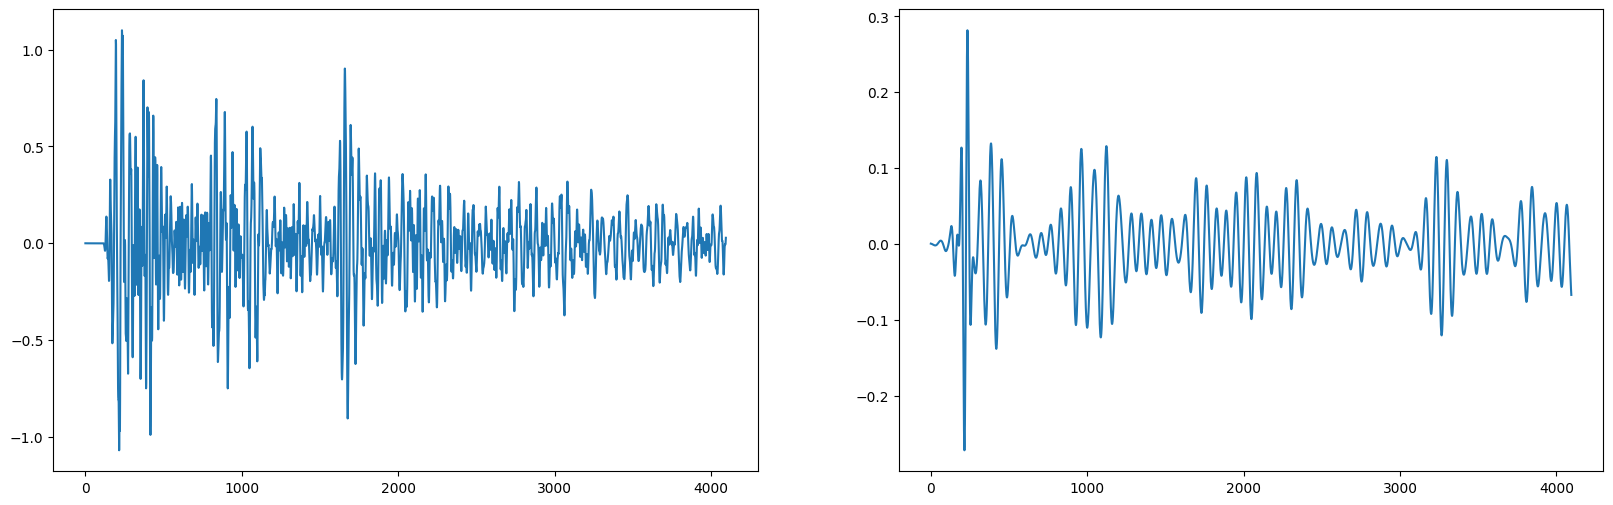

In [11]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(all_samples[1])
ax[1].plot(denoised_samples[1])

# Extraindo features

In [12]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def calculate_time_features(signal):
    mean_val = np.mean(signal)
    variance = np.var(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    peak_val = np.max(np.abs(signal))
    rms = np.sqrt(np.mean(signal**2))
    return [mean_val, variance, skewness, kurt, peak_val, rms]

def calculate_frequency_features(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    total_energy = np.sum(Pxx)
    if total_energy == 0:
        centroid = 0
        bandwidth = 0
    else:
        centroid = np.sum(f * Pxx) / total_energy
        bandwidth = np.sqrt(np.sum(((f - centroid) ** 2) * Pxx) / total_energy)
    return [total_energy, centroid, bandwidth]

def calculate_wavelet_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    relative_energy = np.array([np.sum(np.abs(c)**2) for c in coeffs])
    relative_energy /= np.sum(relative_energy)
    entropy = -np.sum(relative_energy * np.log2(relative_energy + np.finfo(float).eps))
    return [np.sum(relative_energy), entropy]

def extract_features(signal, fs, wavelet='db4'):
    time_features = calculate_time_features(signal)
    frequency_features = calculate_frequency_features(signal, fs)
    wavelet_features = calculate_wavelet_features(signal, wavelet)
    return time_features + frequency_features + wavelet_features


def select_best_wavelet(signal, wavelet_list, level=4):
    min_entropy = float('inf')
    best_wavelet = None
    for wavelet in wavelet_list:
        try:
            _, entropy = calculate_wavelet_features(signal, wavelet, level)
            if entropy < min_entropy:
                min_entropy = entropy
                best_wavelet = wavelet
        except Exception as e:
            print(f"Erro ao usar a wavelet {wavelet}: {e}")
            continue
    return best_wavelet

In [13]:
feature_names = [
    'mean_val',         # Média
    'variance',         # Variância
    'skewness',         # Skewness
    'kurtosis',         # Kurtosis
    'peak_val',         # Valor de Pico
    'rms',              # RMS (Root Mean Square)
    'total_energy',     # Energia Total no domínio da frequência
    'centroid',         # Centroide Espectral
    'bandwidth',        # Banda de Frequência
    'relative_energy',  # Energia Relativa no domínio wavelet
    'entropy'           # Entropia Wavelet
]

In [14]:
data = []
for i in range(denoised_samples.shape[0]):
    time_test = samples_metadata.iloc[i]['TIME OF TEST']
    fs = sampling_period = time_test/4096

    wavelet_list = pywt.wavelist(kind='discrete')
    best_wavelet = select_best_wavelet(denoised_samples[i], wavelet_list,3)

    feats = extract_features(denoised_samples[i],fs,wavelet=best_wavelet)
    data.append(feats)

df = pd.DataFrame(data=data, columns=feature_names)
df['CASE'] = np.concatenate((np.zeros(len(b_samples)), np.ones(len(c_samples))),axis=None)

NameError: name 'samples_metadata' is not defined

In [ ]:
df

,mean_val,variance,skewness,kurtosis,peak_val,rms,total_energy,centroid,bandwidth,relative_energy,entropy,CASE
0,-0.000291,0.041983,0.145630,4.569141,1.151393,0.204898,49743.741748,5.566596e-06,1.584508e-06,1.0,0.764012,0.0
1,-0.000302,0.042133,0.150440,4.608572,1.151496,0.205264,45053.241448,6.171751e-06,1.764886e-06,1.0,0.757712,0.0
2,-0.000297,0.042199,0.152569,4.599578,1.154801,0.205423,41094.753574,6.775236e-06,1.927366e-06,1.0,0.762477,0.0
3,-0.000307,0.042225,0.150261,4.617056,1.150920,0.205488,37764.662666,7.381288e-06,2.111829e-06,1.0,0.755482,0.0
4,-0.000300,0.042177,0.152168,4.584011,1.152413,0.205370,34853.787117,7.983540e-06,2.277679e-06,1.0,0.762685,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
299,-0.000316,0.037434,-0.008030,6.886825,1.080939,0.193478,68958.838191,3.107581e-06,7.209525e-07,1.0,0.319978,1.0
300,-0.000248,0.037418,-0.013678,6.799780,1.063447,0.193437,58632.807894,3.654736e-06,8.509206e-07,1.0,0.300065,1.0
301,-0.000176,0.037411,-0.022022,6.719138,1.045314,0.193419,51009.447757,4.202661e-06,9.843042e-07,1.0,0.285773,1.0
302,-0.000284,0.037443,-0.010018,6.849429,1.075117,0.193502,45168.212492,4.746224e-06,1.102357e-06,1.0,0.311038,1.0


# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=5)
features_selected = selector.fit_transform(df.drop('CASE',axis=1), df['CASE'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
selector.get_feature_names_out()

array(['variance', 'skewness', 'peak_val', 'rms', 'entropy'], dtype=object)

In [ ]:
new_df =pd.DataFrame(data=features_selected, columns=selector.get_feature_names_out())
new_df['CASE'] = df['CASE'].values
new_df

,variance,skewness,peak_val,rms,entropy,CASE
0,0.041983,0.145630,1.151393,0.204898,0.764012,0.0
1,0.042133,0.150440,1.151496,0.205264,0.757712,0.0
2,0.042199,0.152569,1.154801,0.205423,0.762477,0.0
3,0.042225,0.150261,1.150920,0.205488,0.755482,0.0
4,0.042177,0.152168,1.152413,0.205370,0.762685,0.0
...,...,...,...,...,...,...
299,0.037434,-0.008030,1.080939,0.193478,0.319978,1.0
300,0.037418,-0.013678,1.063447,0.193437,0.300065,1.0
301,0.037411,-0.022022,1.045314,0.193419,0.285773,1.0
302,0.037443,-0.010018,1.075117,0.193502,0.311038,1.0


# Classificação

           Média  Intervalo de Confiança
F1 Macro  0.9803                 0.01706
Acurácia  0.9803                 0.01703
Scores macro:
[0.96713362 0.9672043  0.98360656 0.98360656 1.        ]
Scores acuracia:
[0.96721311 0.96721311 0.98360656 0.98360656 1.        ]

Time of prediction: 0.0011076927185058594


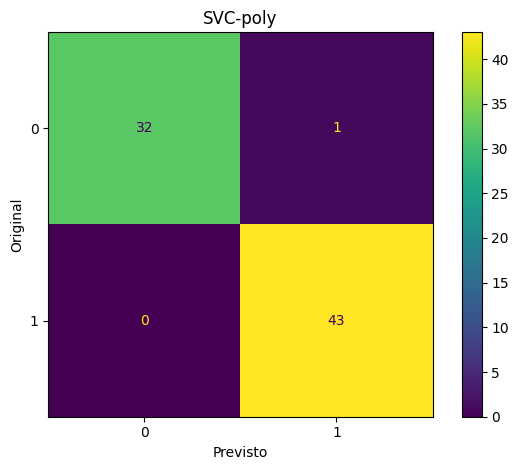

(array([0.96721311, 0.96721311, 0.98360656, 0.98360656, 1.        ]),
 array([0.96713362, 0.9672043 , 0.98360656, 0.98360656, 1.        ]))

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from Pipeline.functions.classification import evaluate_model

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=4, coef0=1, C=5))
])

evaluate_model(new_df, pipeline,title="SVC-poly")

## Grid Search

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(new_df.drop('CASE',axis=1), new_df['CASE'], test_size=0.2, random_state=42)

# Treinar SVM
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf'],}
svm = GridSearchCV(SVC(), param_grid, cv=5)
svm.fit(X_train, y_train)

# Prever e avaliar
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

NameError: name 'accuracy_score' is not defined

In [ ]:
svm.best_params_

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", C=1000))
])

evaluate_model(new_df, pipeline,title="SVC-poly")